# Region Clustering

* Clustering regions in PL, CZ, and SE based on similarities in population and/or density and/or geographical proximity

* Note that clustering is not done separately for SE and PL/CZ groups of countries, but this too can be done

* Visualising clusters of regions in maps as Martin has done is probably desirable, but requires Martin's assistance, as the related package function doesn't seem to work on non-Windows OS'es like mine

### 1. Base Data Pull

* List of all regions in PL, CZ, and SE was pulled; as in Martin's research project paper, regions in CZ and SE are at NUTS3 level, whereas all regions in PL are at a NUTS2 level, except the capital region which is at a NUTS1 level

* Apart from the above-mentioned NUTS IDs, each region has the following attributes: population, area, and (geographical) centroid

In [1]:
import pandas as pd
import numpy as np
regions = pd.read_csv("./data/regions.csv")

### 2. Matrix of pairwise regional geographical distances

* Note that [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) has been employed here. This can of course be changed to Euclidean Distance

* Also, the range of distances has been scaled down to [0, 1]

In [2]:
# geographical distance matrix

import haversine.haversine as haversine

centroids = dict(zip(regions.iloc[:,0], 
                     regions.iloc[:,4].apply(lambda x: [float(i) for i in x.split(',')]))) # set up

geog_dist = pd.DataFrame([[haversine(centroids[reg_row], centroids[reg_col])
                                  for reg_col in regions['NUTS3'].unique()] 
                                 for reg_row in regions['NUTS3'].unique()], 
                                columns = regions['NUTS3'].unique()).rename(
                                dict(enumerate(regions['NUTS3'].unique()))) # actual haversine distance

geog_dist = geog_dist / geog_dist.max().max() # scaled

### 3. Matrix of pairwise regional population dissimilarities

* Base population dissimilarity between a pair of regions was taken as the absolute difference between their populations

* These dissimilarities were then scaled down to [0, 1]

In [3]:
# population dissimilarity matrix

population = dict(zip(regions.iloc[:,0], regions.iloc[:,2])) # set up

pop_diss = pd.DataFrame([[abs(population[reg_row] - population[reg_col])
                                  for reg_col in regions['NUTS3'].unique()] 
                                 for reg_row in regions['NUTS3'].unique()], 
                                columns = regions['NUTS3'].unique()).rename(
                                dict(enumerate(regions['NUTS3'].unique()))) # actual pop difference

pop_diss = pop_diss / pop_diss.max().max() # scaled

### 4. Matrix of pairwise regional population density dissimilarities

* Population density defined here as population per unit of area

* Base population density dissimilarity between a pair of regions was taken as the absolute difference between their population densities

* These dissimilarities were then scaled down to [0, 1]

In [4]:
# population density dissimilarity matrix

population_density = dict(zip(regions.iloc[:,0], regions.iloc[:,2]/regions.iloc[:,3])) # set up

pop_dens_diss = pd.DataFrame([[abs(population_density[reg_row] - population_density[reg_col])
                                  for reg_col in regions['NUTS3'].unique()] 
                                 for reg_row in regions['NUTS3'].unique()], 
                                columns = regions['NUTS3'].unique()).rename(
                                dict(enumerate(regions['NUTS3'].unique()))) # actual pop density difference

pop_dens_diss = pop_dens_diss / pop_dens_diss.max().max() # scaled

### 5. Adjacency Matrix

* Built entirely using Martin's package method "location.adjacency_similarity_matrix()"
* Distances in the matrix are already in [0, 1] scale

In [5]:
# adjacency (dis)similarity matrix

import sys
sys.path.append("src")

import location
adj_matrix, adj_matrix_nuts = location.adjacency_similarity_matrix() # load adjacency (dis)similarity matrix

adj_matrix = pd.DataFrame(adj_matrix, columns = adj_matrix_nuts).rename(dict(enumerate(adj_matrix_nuts))) # format into pandas data frame
adj_matrix = adj_matrix.reindex(index=regions['NUTS3'].unique(), columns=regions['NUTS3'].unique()) # shuffle labels to match other matrices

/Users/stray/miniconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


### 6. Composite distance matrices
* We build composite distance matrices by combining **n** (**n** >= 1) distance matrices built above

* Specifically, for a given pair of regions, we treat the distance metric from each component distance matrix as a coordinate of an **n** dimensional vector and compute composite distance between the pair as the euclidean norm of this vector

In [6]:
# composite distance matrices

all_four_distances = np.sqrt(pop_diss**2 + pop_dens_diss**2 + geog_dist**2 + adj_matrix**2)
all_except_geog = np.sqrt(pop_diss**2 + pop_dens_diss**2 + adj_matrix**2)
all_except_adj = np.sqrt(pop_diss**2 + pop_dens_diss**2 + geog_dist**2)
all_except_pop = np.sqrt(adj_matrix**2 + pop_dens_diss**2 + geog_dist**2)
pop_pop_dens = np.sqrt(pop_diss**2 + pop_dens_diss**2)
pop_dens = pop_dens_diss
pop_dens_adj = np.sqrt(pop_dens_diss**2 + adj_matrix**2)
pop_dens_geog = np.sqrt(pop_dens_diss**2 + geog_dist**2)

### 7. Clustering using Czekanowski Diagrams

* It seems this may be the preferred way to cluster regions in this project is to use Czekanowski Diagrams

* So I tried to import and use the 'RMaCzek' package here in a Python environment for the job, but had issues. See error screenshot

<img src="misc/r_package_error.png" alt="Error Screenshot" style="width: 500px;"/>

* Setting up environmental variables did not help either:

<img src="misc/env_vars.png" alt="Environment Variables" style="width: 500px;"/>

* So had to export data to R and to the job there. See file "czekonovsky_clustering.R"

In [7]:
# export data files to csv
all_four_distances.to_csv('./data/clustering_distance_datasets/all_four_distances.csv')
all_except_geog.to_csv('./data/clustering_distance_datasets/all_except_geog.csv')
all_except_adj.to_csv('./data/clustering_distance_datasets/all_except_adj.csv')
all_except_pop.to_csv('./data/clustering_distance_datasets/all_except_pop.csv')
pop_pop_dens.to_csv('./data/clustering_distance_datasets/pop_pop_dens.csv')
pop_dens.to_csv('./data/clustering_distance_datasets/pop_dens.csv')
pop_dens_adj.to_csv('./data/clustering_distance_datasets/pop_dens_adj.csv')
pop_dens_geog.to_csv('./data/clustering_distance_datasets/pop_dens_geog.csv')

#### Results from R: (Code available for tweaking)

**7.1.** Clustering based on composite distance using all four components (geographical, adjacency, population and population density) with 'n_class = 6':

<img src="output/img/clustering_czekanovski_R/all_four_distances_cd.png" alt="All Four" style="width: 500px;"/>

**7.2.** Clustering based on composite distance using three components viz. adjacency, population and population density with 'n_class = 6':

<img src="output/img/clustering_czekanovski_R/all_except_geog_cd.png" alt="All Four except Euclidean Geographical Distance" style="width: 500px;"/>

**7.3.** Clustering based on composite distance using three components viz. geographical, population and population density with 'n_class = 6':

<img src="output/img/clustering_czekanovski_R/all_except_adj_cd.png" alt="All Four except Adjacency Matriix" style="width: 500px;"/>

**7.4.** Clustering based on composite distance using three components viz. geographical, adjacency and population density with 'n_class = 6':

<img src="output/img/clustering_czekanovski_R/all_except_pop_cd.png" alt="All Four except Population" style="width: 500px;"/>

**7.5.** Clustering based on composite distance using two components viz. population and population density with 'n_class = 6':

<img src="output/img/clustering_czekanovski_R/pop_pop_dens_cd.png" alt="Population and Population Density" style="width: 500px;"/>

**7.6.** Clustering based on composite distance using population density alone, with 'n_class = 6':

<img src="output/img/clustering_czekanovski_R/pop_dens_cd.png" alt="Population Density Alone" style="width: 500px;"/>

**7.7.** Clustering based on composite distance using two components viz. population density and adjacency with 'n_class = 6':

<img src="output/img/clustering_czekanovski_R/pop_dens_adj_cd.png" alt="Population Density and Adjacency" style="width: 500px;"/>

**7.8.** Clustering based on composite distance using two components viz. population density and geographical distance with 'n_class = 6':

<img src="output/img/clustering_czekanovski_R/pop_dens_geog_cd.png" alt="Population Density and Geographic Distance" style="width: 500px;"/>

### 8. Hierarchical Clustering using Distance Heatmaps

**8.1.** Clustering based on composite distance using all four components (geographical, adjacency, population and population density) with 'n_class = 6':

/Users/stray/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


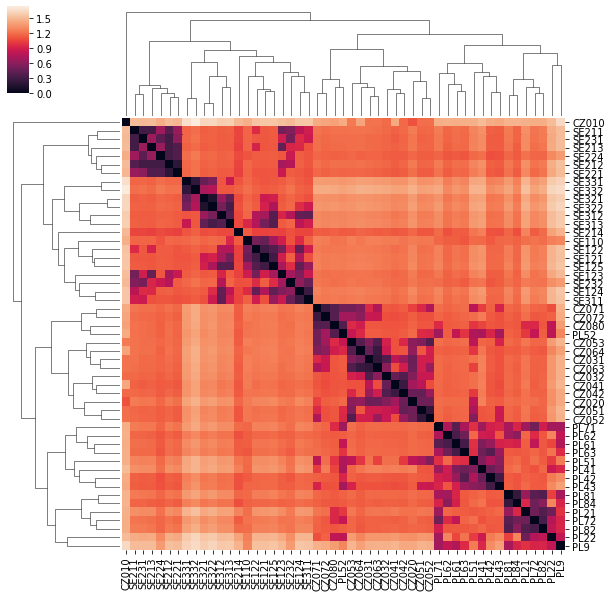

In [8]:
import seaborn as sns
sns.clustermap(all_four_distances, xticklabels = True, yticklabels = True, figsize = (10, 10))

**8.2.** Clustering based on composite distance using three components viz. adjacency, population and population density with 'n_class = 6':

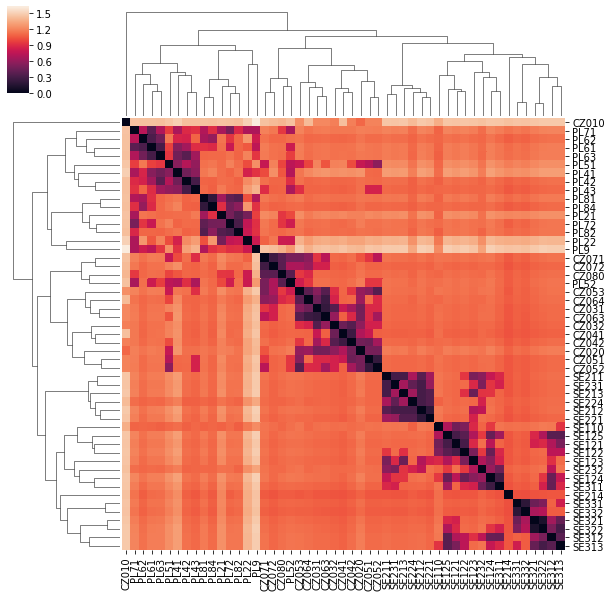

In [9]:
sns.clustermap(all_except_geog, xticklabels = True, yticklabels = True, figsize = (10, 10))

**8.3.** Clustering based on composite distance using three components viz. geographical distance, population and population density with 'n_class = 6':

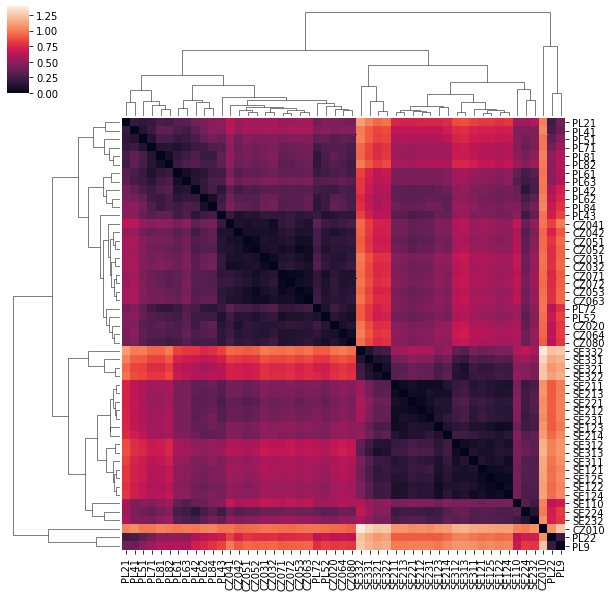

In [10]:
sns.clustermap(all_except_adj, xticklabels = True, yticklabels = True, figsize = (10, 10))

**8.4.** Clustering based on composite distance using three components viz. geographical distance, adjacency and population density with 'n_class = 6':

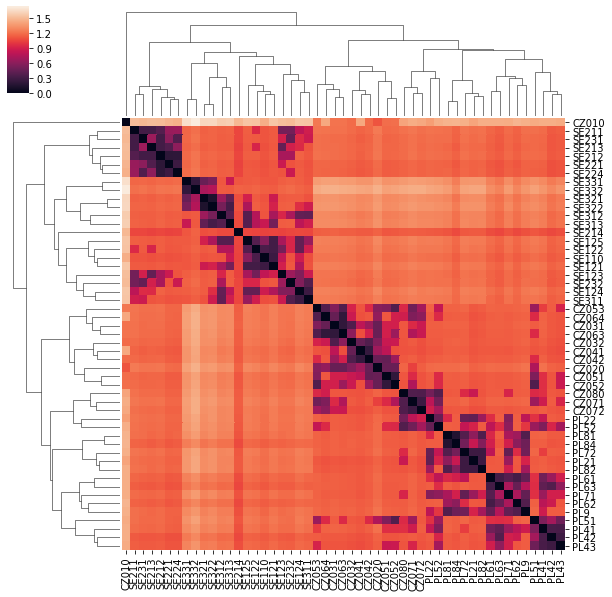

In [11]:
sns.clustermap(all_except_pop, xticklabels = True, yticklabels = True, figsize = (10, 10))

**8.5.** Clustering based on composite distance using two components viz. population and population density with 'n_class = 6':

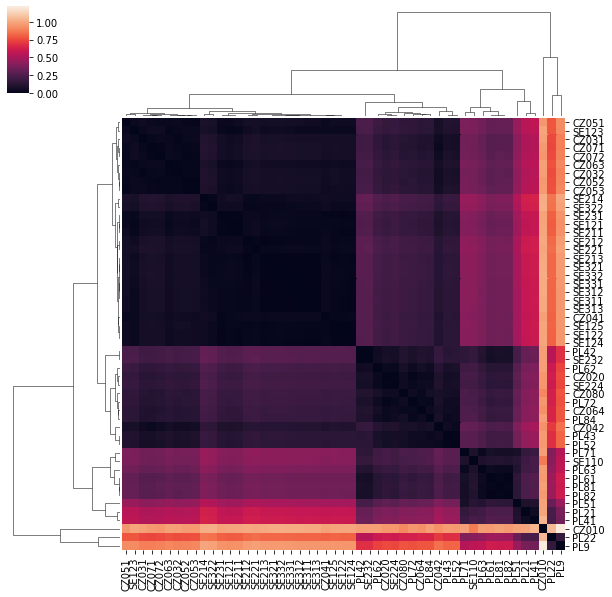

In [12]:
sns.clustermap(pop_pop_dens, xticklabels = True, yticklabels = True, figsize = (10, 10))

**8.6.** Clustering based on population density, with 'n_class = 6':

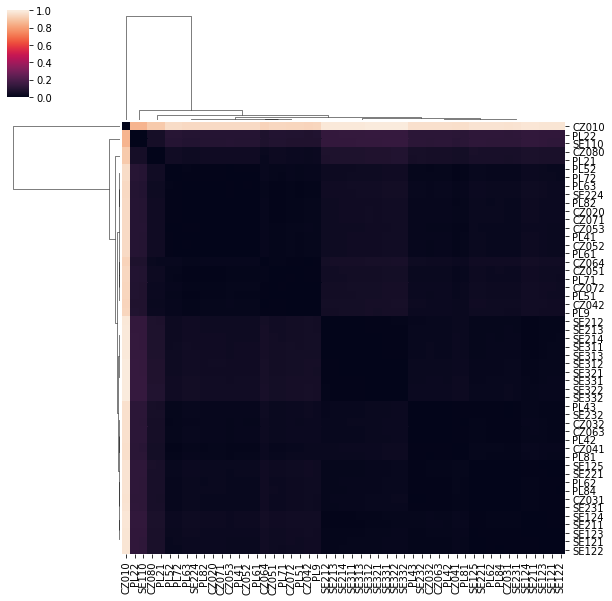

In [13]:
sns.clustermap(pop_dens, xticklabels = True, yticklabels = True, figsize = (10, 10))

**8.7.** Clustering based on composite distance using two components viz. adjacency and population density with 'n_class = 6':

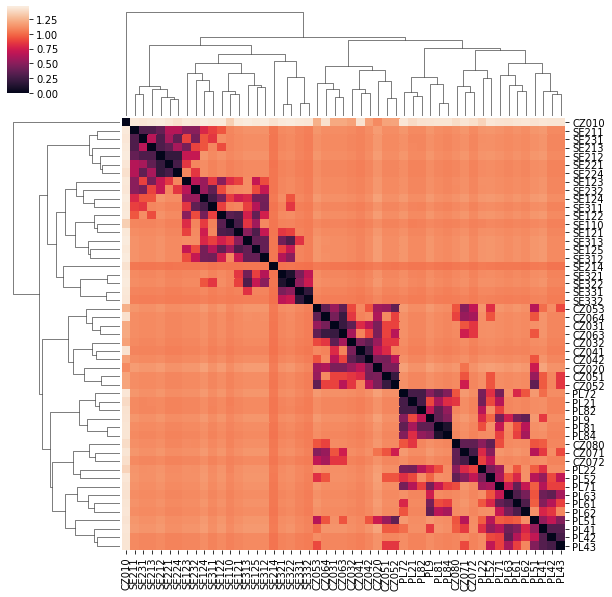

In [14]:
sns.clustermap(pop_dens_adj, xticklabels = True, yticklabels = True, figsize = (10, 10))

**8.8.** Clustering based on composite distance using two components viz. geographical distance and population density with 'n_class = 6':

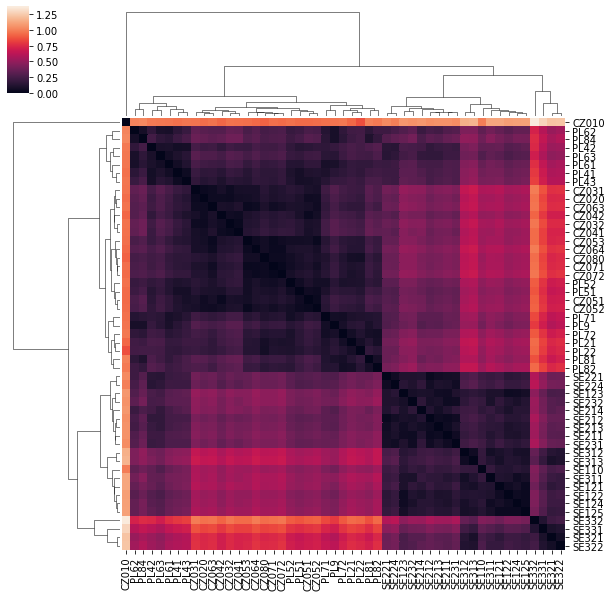

In [15]:
sns.clustermap(pop_dens_geog, xticklabels = True, yticklabels = True, figsize = (10, 10))

### 9. Spectral Clustering

NOTE: There seems to be some bug in sklearn.cluster.SpectralClustering, which gets trigerred when using any other composite distance matrices developed other than the two below

**9.1.** Clustering based on composite distance using two components (population and population density) with 'n_class = 6':

In [16]:
from sklearn.cluster import SpectralClustering

spectral_pop_pop_dens = SpectralClustering(n_clusters=6, assign_labels="discretize",
        random_state=0, affinity = 'precomputed').fit(1 - pop_pop_dens)

spectral_pop_pop_dens = pd.DataFrame(zip(regions['NUTS3'], spectral_pop_pop_dens.labels_), 
                                     columns = ["NUTS3","Cluster"])

/Users/stray/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/Users/stray/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


In [17]:
spectral_pop_pop_dens

,NUTS3,Cluster
0,CZ010,3
1,CZ020,0
2,CZ031,5
3,CZ032,5
4,CZ041,2
5,CZ042,5
6,CZ051,5
7,CZ052,5
8,CZ053,5
9,CZ063,5


**9.2.** Clustering based on population density alone, with 'n_class = 6':

In [18]:
spectral_pop_dens = SpectralClustering(n_clusters=6, assign_labels="discretize",
        random_state=0, affinity = 'precomputed').fit(1 - pop_dens)

spectral_pop_dens = pd.DataFrame(zip(regions['NUTS3'], spectral_pop_dens.labels_), 
                                     columns = ["NUTS3","Cluster"])

In [19]:
spectral_pop_dens

,NUTS3,Cluster
0,CZ010,4
1,CZ020,0
2,CZ031,2
3,CZ032,5
4,CZ041,5
5,CZ042,3
6,CZ051,3
7,CZ052,0
8,CZ053,0
9,CZ063,5


### 10. Appendix

#### 10.1. NUTS labels used (graphical form)

* Graphics copy pasted from Martin's report

<img src="misc/CS_PL_NUTS.png" alt="CS PL NUTS" style="width: 500px;"/>

<img src="misc/SE_NUTS.png" alt="SE NUTS" style="width: 500px;"/>

#### 10.2. NUTS labels used (tabular form)

In [20]:
regions

,NUTS3,name,population,area,centroid
0,CZ010,Prague,1267449,496.1,"50.0663,14.463"
1,CZ020,Central Bohemian,1326876,11016.1,"49.7423,14.4549"
2,CZ031,South Bohemian,637834,10058.0,"49.1031,14.4121"
3,CZ032,Plzeň,576616,7561.0,"49.5984,13.2182"
4,CZ041,Karlovy Vary,297828,3314.3,"50.1699,12.7187"
5,CZ042,Ústí nad Labem,822826,5334.6,"50.5298,13.839"
6,CZ051,Liberec,439639,3163.4,"50.7347,14.9746"
7,CZ052,Hradec Králové,551421,4759.0,"50.3898,15.857"
8,CZ053,Pardubice,516149,4518.9,"49.8748,16.5068"
9,CZ063,Vysočina,509475,6795.6,"49.4183,15.679"
